In [1]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
import vb_lib.structure_optimization_lib as str_opt_lib

import paragami
import vittles

from copy import deepcopy

import argparse
import distutils.util

import os

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Draw data

In [7]:
n_obs = 50
n_loci = 40
n_pop = 4

In [8]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

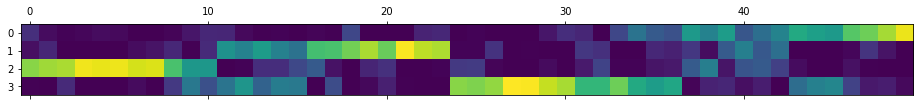

In [9]:
plt.matshow(true_ind_admix_propn.T)

In [10]:
g_obs.shape

(50, 40, 3)

# Get prior

In [11]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [13]:
k_approx = 12

In [14]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [15]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (40, 12, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (50, 11, 2) (lb=0.0, ub=inf)


## Initialize 

In [16]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                use_logitnormal_sticks)

In [17]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_opt_dict['ind_mix_stick_propn_mean'], 
                            vb_opt_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

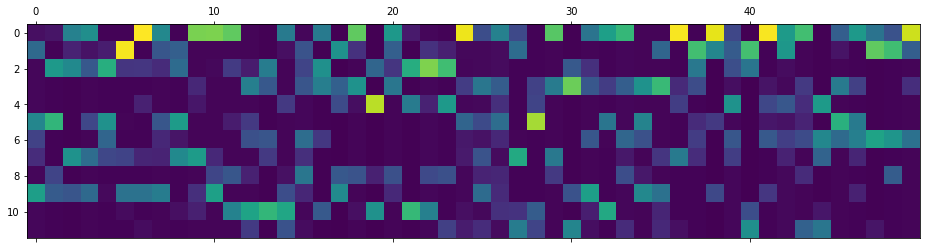

In [18]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())

# Run CAVI

In [19]:
# get beta parameters for sticks and populations
ez_opt, vb_opt_dict = \
    cavi_lib.run_cavi(g_obs, vb_params_dict, 
                        prior_params_dict,
                        use_logitnormal_sticks, 
                        max_iter = 1000,
                        f_tol = 1e-4)


iteration [0]; kl:5697.342035
iteration [1]; kl:4524.753067
iteration [2]; kl:4306.098206
iteration [3]; kl:4250.746505
iteration [4]; kl:4219.155074
iteration [5]; kl:4192.924338
iteration [6]; kl:4168.548303
iteration [7]; kl:4144.862477
iteration [8]; kl:4121.416351
iteration [9]; kl:4098.057939
iteration [10]; kl:4074.777182
iteration [11]; kl:4051.655182
iteration [12]; kl:4028.845861
iteration [13]; kl:4006.54857
iteration [14]; kl:3984.983242
iteration [15]; kl:3964.372147
iteration [16]; kl:3944.882469
iteration [17]; kl:3926.546139
iteration [18]; kl:3909.237155
iteration [19]; kl:3892.731904
iteration [20]; kl:3876.803849
iteration [21]; kl:3861.292951
iteration [22]; kl:3846.128413
iteration [23]; kl:3831.326473
iteration [24]; kl:3816.995504
iteration [25]; kl:3803.340066
iteration [26]; kl:3790.62996
iteration [27]; kl:3779.136603
iteration [28]; kl:3769.05016
iteration [29]; kl:3760.409014
iteration [30]; kl:3753.098705
iteration [31]; kl:3746.907936
iteration [32]; kl:37

iteration [271]; kl:3628.733684
iteration [272]; kl:3628.644233
iteration [273]; kl:3628.539403
iteration [274]; kl:3628.416244
iteration [275]; kl:3628.271298
iteration [276]; kl:3628.100601
iteration [277]; kl:3627.899752
iteration [278]; kl:3627.66411
iteration [279]; kl:3627.389214
iteration [280]; kl:3627.071512
iteration [281]; kl:3626.709507
iteration [282]; kl:3626.305339
iteration [283]; kl:3625.866614
iteration [284]; kl:3625.407956
iteration [285]; kl:3624.951261
iteration [286]; kl:3624.523513
iteration [287]; kl:3624.151607
iteration [288]; kl:3623.855302
iteration [289]; kl:3623.641346
iteration [290]; kl:3623.502198
iteration [291]; kl:3623.420478
iteration [292]; kl:3623.376457
iteration [293]; kl:3623.354046
iteration [294]; kl:3623.342814
iteration [295]; kl:3623.337021
iteration [296]; kl:3623.333827
iteration [297]; kl:3623.3319
iteration [298]; kl:3623.330622
iteration [299]; kl:3623.329697
iteration [300]; kl:3623.328982
iteration [301]; kl:3623.328401
iteration [

In [20]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

In [21]:
objective = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

objective_fun = lambda x, y: objective(g_obs, x, y, use_logitnormal_sticks = False)


In [22]:
import scipy as osp

In [23]:
continue_with_newton = False

if continue_with_newton: 
    
    get_loss = lambda x : objective_fun(x, prior_params_free)
    get_loss_objective = paragami.OptimizationObjective(get_loss)
    
    res = osp.optimize.minimize(
                fun=get_loss_objective.f,
                jac=get_loss_objective.grad,
                hess=get_loss_objective.hessian,
                x0=vb_params_paragami.flatten(vb_params_dict, free = True),
                method='trust-exact', options={'disp':True})
    
    
    print('\nlinf diff in vb_params: ', np.abs(res.x - vb_opt).max())
    
    vb_opt = deepcopy(res.x)
    vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)
    ez_opt = str_opt_lib.get_e_z_from_vb_params_dict(g_obs, vb_opt_dict, use_logitnormal_sticks)


# Check results

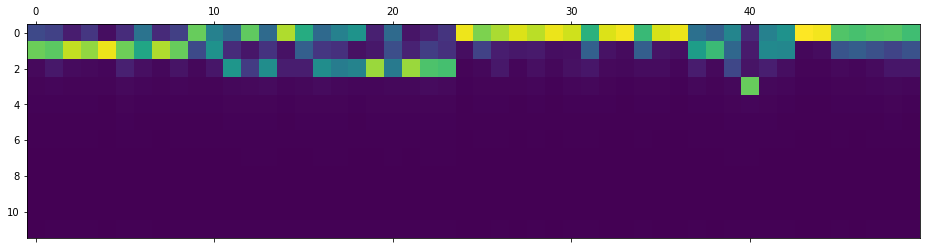

In [24]:
plt.matshow(get_vb_expectations(vb_opt_dict, use_logitnormal_sticks)[0].transpose())

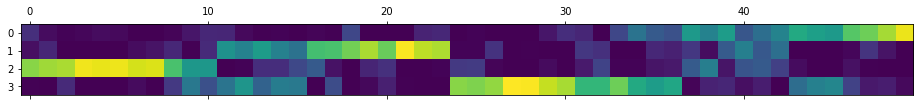

In [25]:
plt.matshow(true_ind_admix_propn.transpose())

# Check optimum

In [26]:
# get hessian 
t0 = time.time()
get_hess = autograd.hessian(objective_fun, argnum = 0)
hessian_at_opt = get_hess(vb_opt, prior_params_free)
print('hessian time: {}sec'.format(np.round(time.time() - t0, 3)))

hess_solver = vittles.solver_lib.get_cholesky_solver(hessian_at_opt)

hessian time: 39.688sec


In [27]:
# gradient 
get_objective_grad = autograd.jacobian(objective_fun, argnum = 0)

In [28]:
optimum_checker = vittles.bivariate_sensitivity_lib.OptimumChecker(
                                                estimating_equation = get_objective_grad, 
                                                solver = hess_solver, 
                                                input_base = vb_opt, 
                                                hyper_base = prior_params_free)


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/vittles/bivariate_sensitivity_lib.py:32: UserWarning: The CrossSensitivity class is very experimental and untested.
  warnings.warn(


In [29]:
newton_step = optimum_checker.get_newton_step()

In [30]:
np.abs(newton_step).max()

0.02266748176140597

# Parametric sensitivity

### Hyper parameter sensitivity object

In [31]:
vb_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = objective_fun, 
        opt_par_value = vb_opt, 
        hyper_par_value = prior_params_free, 
        hessian_at_opt = hessian_at_opt)


### Set new prior

In [32]:
new_alpha = np.array([4.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['dp_prior_alpha'] = new_alpha


In [33]:
print('initial alpha, ', prior_params_dict['dp_prior_alpha'])
print('perturbed alpha, ', prior_params_pert_dict['dp_prior_alpha'])

initial alpha,  [3.]
perturbed alpha,  [4.]


In [34]:
lr_vb_free_params = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami.flatten(prior_params_pert_dict, free = True))


In [35]:
print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))


l_inf diff:  0.6145781103053327


### Re-optimize

In [36]:
new_init_dict = deepcopy(vb_opt_dict)
# new_init_dict = deepcopy(init_vb_params_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)


In [37]:
# get beta parameters for sticks and populations
ez_pert, vb_pert_dict = \
    cavi_lib.run_cavi(g_obs, new_init_dict, 
                        prior_params_pert_dict,
                        use_logitnormal_sticks, 
                        max_iter = 1000,
                        f_tol = 1e-4)


iteration [0]; kl:3886.557273
iteration [1]; kl:3878.658115
iteration [2]; kl:3876.615144
iteration [3]; kl:3875.803686
iteration [4]; kl:3875.406943
iteration [5]; kl:3875.183931
iteration [6]; kl:3875.044537
iteration [7]; kl:3874.949749
iteration [8]; kl:3874.880826
iteration [9]; kl:3874.828008
iteration [10]; kl:3874.785852
iteration [11]; kl:3874.751147
iteration [12]; kl:3874.721895
iteration [13]; kl:3874.696792
iteration [14]; kl:3874.674953
iteration [15]; kl:3874.655753
iteration [16]; kl:3874.638733
iteration [17]; kl:3874.623549
iteration [18]; kl:3874.609933
iteration [19]; kl:3874.597672
iteration [20]; kl:3874.586596
iteration [21]; kl:3874.576561
iteration [22]; kl:3874.56745
iteration [23]; kl:3874.559161
iteration [24]; kl:3874.551607
iteration [25]; kl:3874.544715
iteration [26]; kl:3874.538419
iteration [27]; kl:3874.53266
iteration [28]; kl:3874.527389
iteration [29]; kl:3874.52256
iteration [30]; kl:3874.518133
iteration [31]; kl:3874.514071
iteration [32]; kl:38

In [38]:
vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)

### Compare lr vs reoptimizing

In [39]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


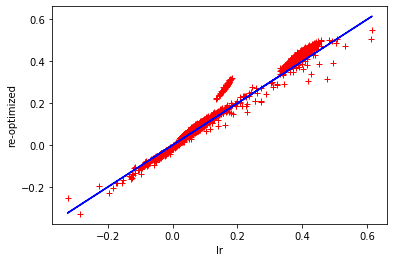

In [40]:
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [41]:
objective_fun(lr_vb_free_params, prior_params_paragami.flatten(prior_params_pert_dict, free = True))

3874.7822346757303

In [42]:
objective_fun(vb_opt_pert, prior_params_paragami.flatten(prior_params_pert_dict, free = True))

3874.4676335505387

# Fit for a range of alpha

In [43]:
alpha_list = np.arange(1, 15)

In [44]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha

    # get beta parameters for sticks and populations
    ez_pert, vb_pert_dict = \
        cavi_lib.run_cavi(g_obs, new_init_dict, 
                            prior_params_pert_dict,
                            use_logitnormal_sticks, 
                            max_iter = 1000,
                            f_tol = 1e-4, 
                             print_every = 1e16)

    vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)   
        
    return vb_opt_pert


In [45]:
vb_pert_list = []
for alpha in alpha_list: 
    print('\nre-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, new_init_dict))



re-optimzing with alpha =  1
iteration [0]; kl:2910.553397
CAVI done. Termination after 434 steps in 6.82 seconds

re-optimzing with alpha =  2
iteration [0]; kl:3311.692837
CAVI done. Termination after 91 steps in 1.2 seconds

re-optimzing with alpha =  3
iteration [0]; kl:3623.324797
CAVI done. Termination after 1 steps in 0.03 seconds

re-optimzing with alpha =  4
iteration [0]; kl:3886.557273
CAVI done. Termination after 78 steps in 1.18 seconds

re-optimzing with alpha =  5
iteration [0]; kl:4118.263396
CAVI done. Termination after 92 steps in 1.22 seconds

re-optimzing with alpha =  6
iteration [0]; kl:4327.300087
CAVI done. Termination after 148 steps in 2.4 seconds

re-optimzing with alpha =  7
iteration [0]; kl:4518.994788
CAVI done. Termination after 161 steps in 3.08 seconds

re-optimzing with alpha =  8
iteration [0]; kl:4696.846949
CAVI done. Termination after 305 steps in 4.35 seconds

re-optimzing with alpha =  9
iteration [0]; kl:4863.302325
CAVI done. Termination afte

In [46]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami.flatten(prior_params_pert_dict, free = True)))

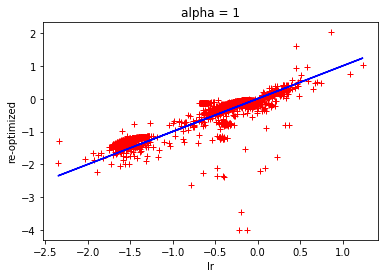

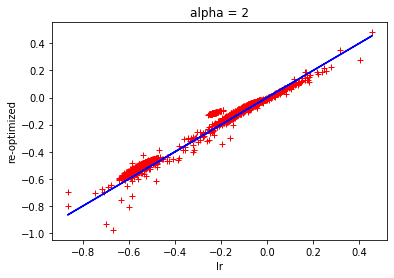

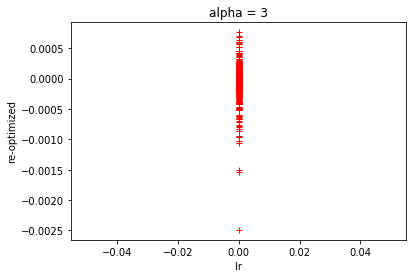

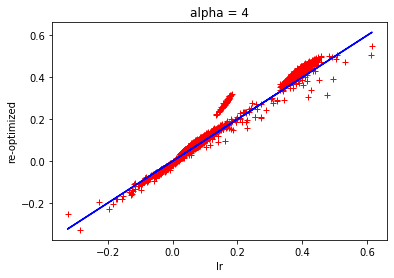

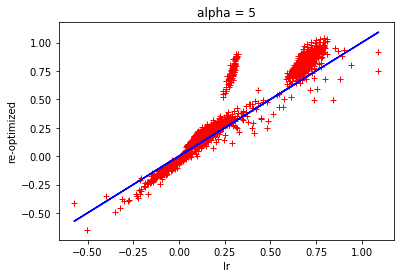

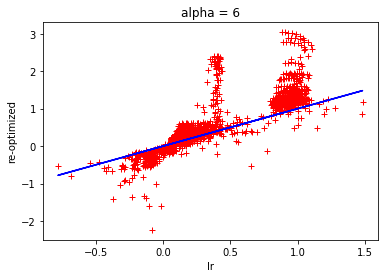

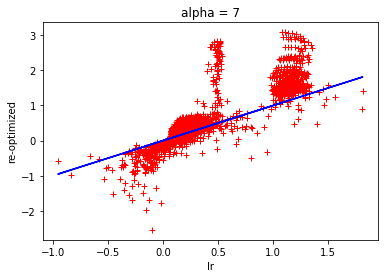

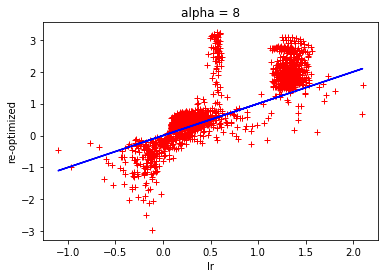

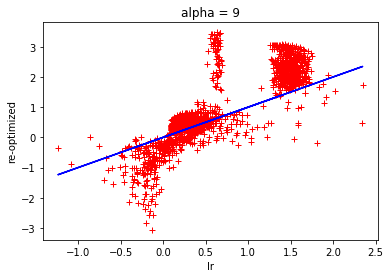

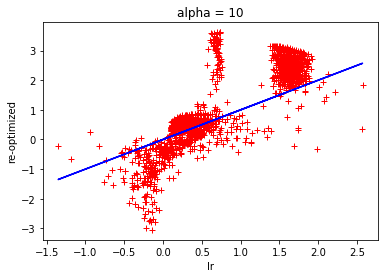

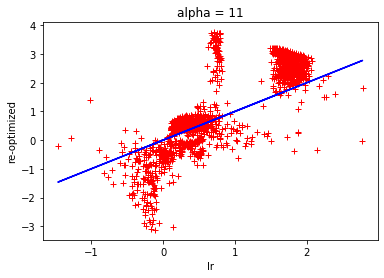

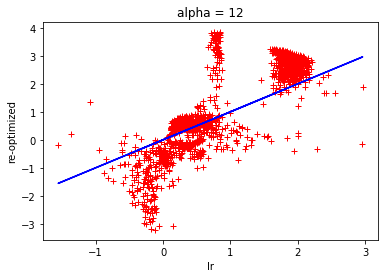

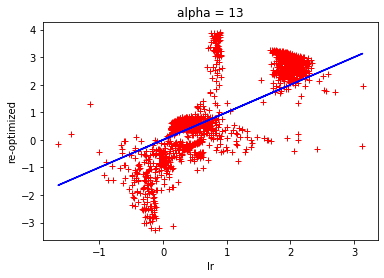

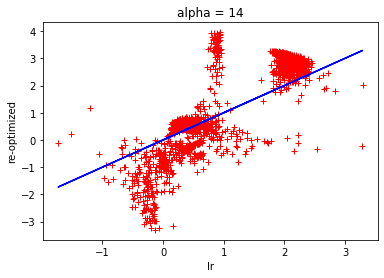

In [47]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))


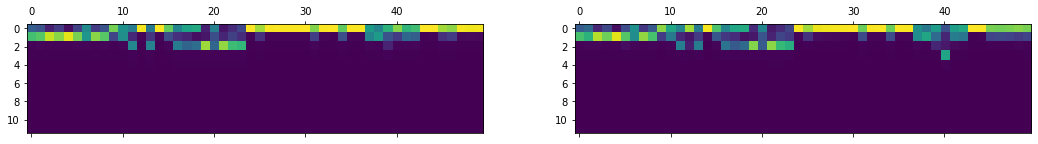

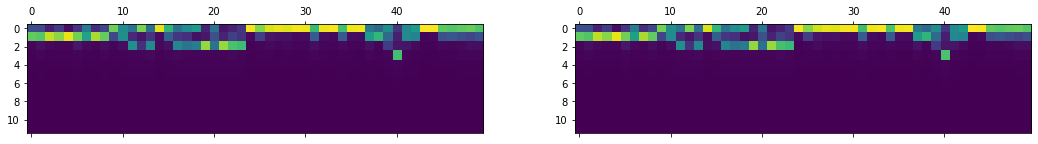

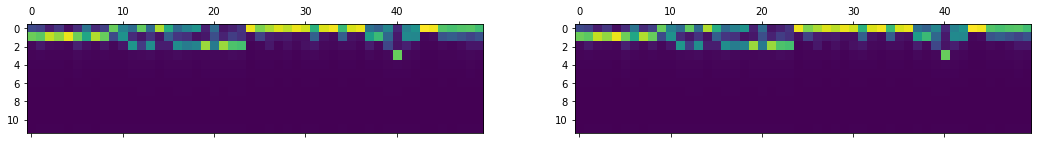

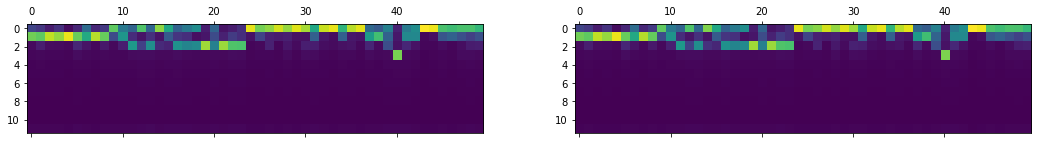

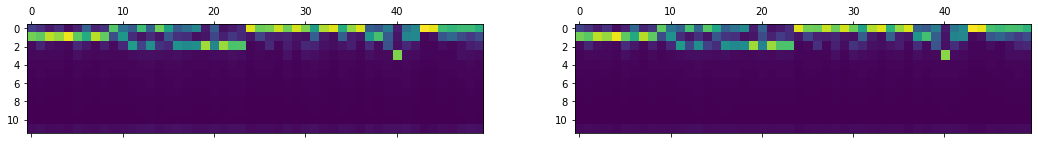

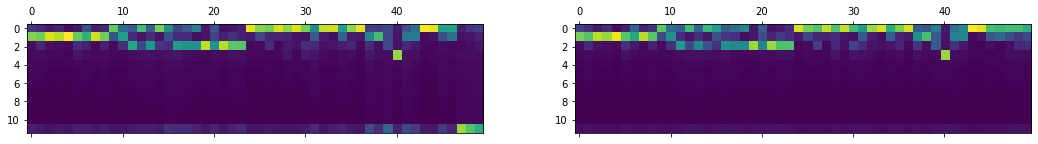

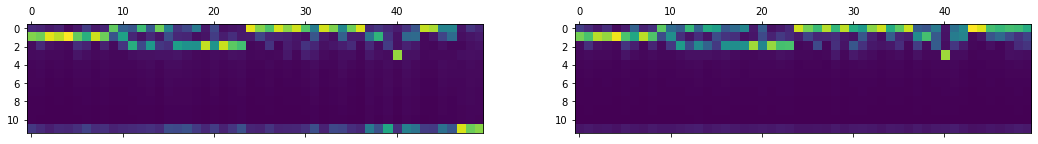

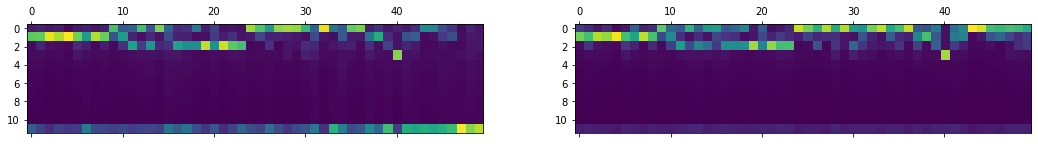

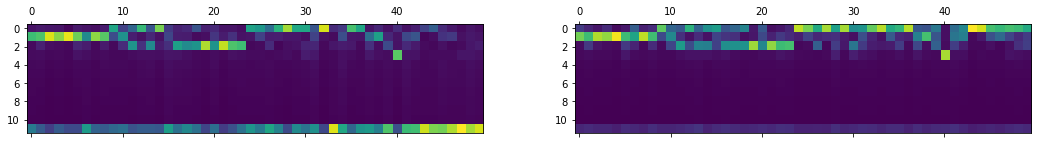

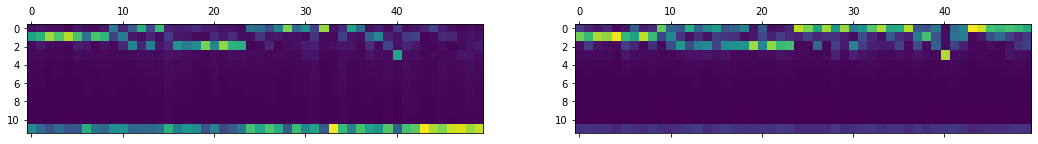

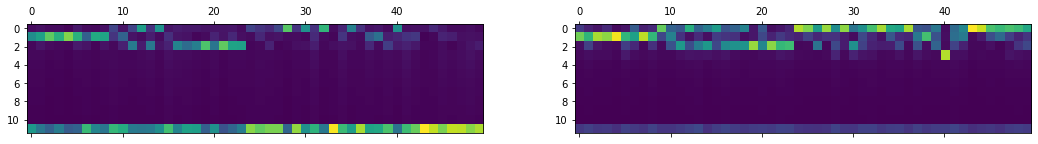

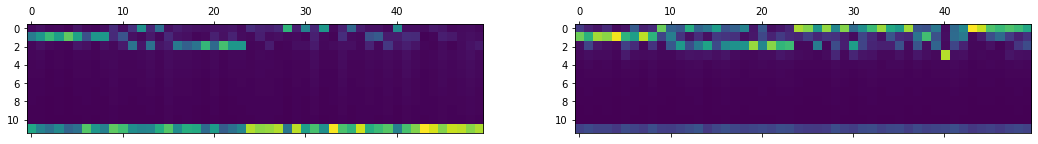

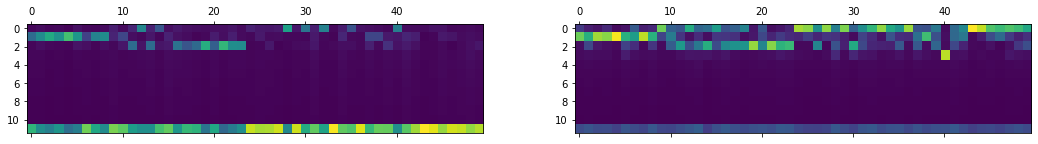

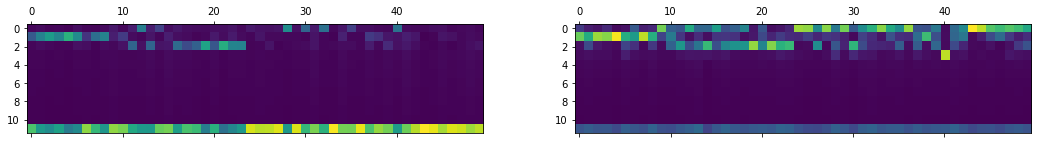

In [55]:
for i in range(len(alpha_list)): 

    fig, axes = plt.subplots(1, 2, figsize = (18, 4))

    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    
    axes[0].matshow(get_vb_expectations(pert_dict, use_logitnormal_sticks)[0].transpose())
    axes[1].matshow(get_vb_expectations(lr_dict, use_logitnormal_sticks)[0].transpose())


### Examine expected number of clusters

In [49]:
n_samples = 10000
unif_samples = np.random.random((n_obs, n_samples))

threshold = 0

In [50]:
e_num_clusters_lr = np.zeros(len(alpha_list))
e_num_clusters_pert = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)

    # these are individual belongings
    pert_e_ind_admix, _ = get_vb_expectations(pert_dict, use_logitnormal_sticks)
    
    lr_e_ind_admix, _ = get_vb_expectations(lr_dict, use_logitnormal_sticks)
    
    # get expected number of clusters
    
    # this isn't quite right : we are treating the individual admixtures like multinomial probabilities, 
    # not a stick-breaking process
    e_num_clusters_lr[i] = cluster_quantities_lib.get_e_num_large_clusters_from_ez(lr_e_ind_admix,
                                threshold,
                                unif_samples = unif_samples)[0]
    
    e_num_clusters_pert[i] = cluster_quantities_lib.get_e_num_large_clusters_from_ez(pert_e_ind_admix,
                                threshold,
                                unif_samples = unif_samples)[0]

In [69]:
lr_e_ind_admix.shape

(50, 12)

Text(0, 0.5, 'expected number of clusters')

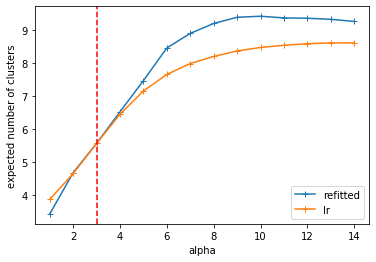

In [51]:
plt.plot(alpha_list, e_num_clusters_pert, '+-')
plt.plot(alpha_list, e_num_clusters_lr, '+-')

plt.axvline(x = prior_params_dict['dp_prior_alpha'], linestyle = '--', color = 'r')

plt.legend(('refitted', 'lr'))

plt.xlabel('alpha')
plt.ylabel('expected number of clusters')

In [63]:
vb_opt_dict['pop_freq_beta_params'].shape

(40, 12, 2)

In [64]:
prior_params_dict

{'dp_prior_alpha': array([3.]),
 'allele_prior_alpha': array([1.]),
 'allele_prior_beta': array([1.])}

In [67]:
vb_opt_dict['ind_mix_stick_beta_params'].shape

(50, 11, 2)